<a href="https://colab.research.google.com/github/Lezginchik64/Colab_Projects/blob/main/practical_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Задача 1. Обнаружение фальшивых новостей

In [ ]:
url = 'https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv'
data = pd.read_csv(url)
print(data.head())
print('')
print(data['label'].value_counts())

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [ ]:
X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5068,)
Размер тестовой выборки: (1267,)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)      # stop_words='english' удаляет часто встречающиеся, но неинформативные слова
                                                                          # max_df=0.7 игнорирует слова, которые встречаются более чем в 70% текстов.

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)                   # Преобразуем обучающие тексты в числовую матрицу TF-IDF.
X_test_tfidf = tfidf_vectorizer.transform(X_test)                         # Преобразуем тестовые тексты в числовую матрицу

In [ ]:
# Обучения модели
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac.fit(X_train_tfidf, y_train)
y_pred = pac.predict(X_test_tfidf)                                        # Метод predict() делает предсказания для тестовых данных.
accuracy = accuracy_score(y_test, y_pred)                                 # точность модели
print(f"Точность модели: {accuracy * 100:.2f}%")

Точность модели: 93.76%


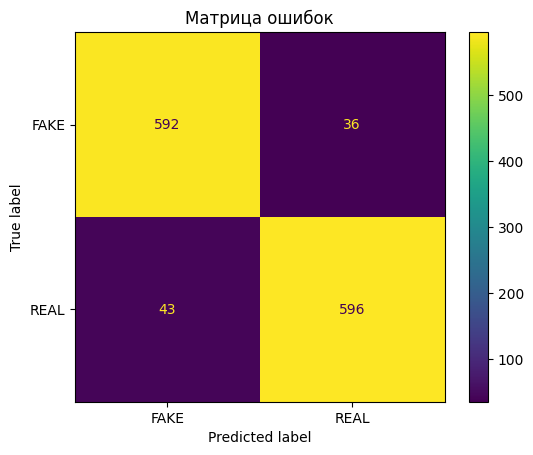

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['FAKE', 'REAL'])
disp.plot(cmap='viridis')                                                 # матрица ошибок
plt.title("Матрица ошибок")
plt.show()

Наиболее важные слова для класса REAL: ['debate' 'candidates' 'tuesday' 'islamic' 'friday' 'cruz' 'marriage'
 'conservative' 'says' 'said']
Наиболее важные слова для класса FAKE: ['2016' 'october' 'article' 'hillary' 'share' 'november' 'source' 'snip'
 'print' 'email']



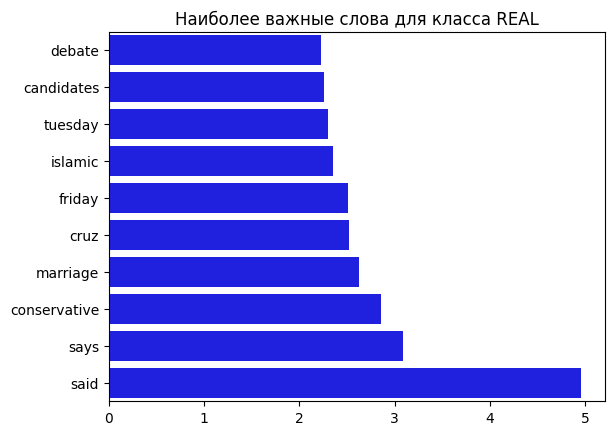

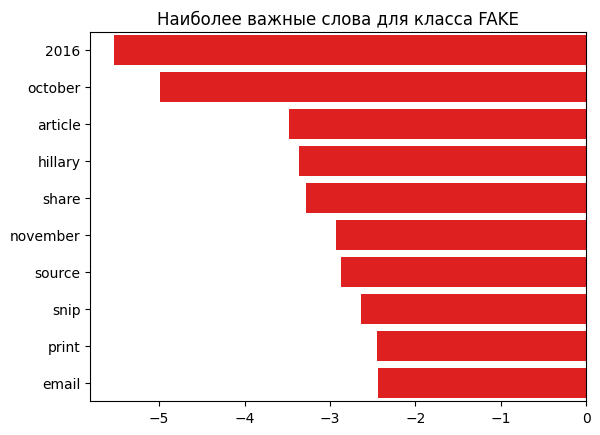

In [ ]:
# Извлекаем важные слова
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
sorted_coef_index = pac.coef_[0].argsort()

# Наиболее влиятельные слова
top_positive_words = feature_names[sorted_coef_index[-10:]]
top_negative_words = feature_names[sorted_coef_index[:10]]

print("Наиболее важные слова для класса REAL:", top_positive_words)
print("Наиболее важные слова для класса FAKE:", top_negative_words)
print('')

sns.barplot(x=pac.coef_[0][sorted_coef_index[-10:]], y=top_positive_words, color='blue')
plt.title("Наиболее важные слова для класса REAL")
plt.show()

sns.barplot(x=pac.coef_[0][sorted_coef_index[:10]], y=top_negative_words, color='red')
plt.title("Наиболее важные слова для класса FAKE")
plt.show()

# Задача 2. Обнаружение болезни паркинсона с помощью XGBoost

In [ ]:
with open('/content/67706e65766b11.51910885parkinsons.names', 'r', encoding='utf-8') as file:
    content = file.read()
print(content)

Title: Parkinsons Disease Data Set

Abstract: Oxford Parkinson's Disease Detection Dataset

-----------------------------------------------------	

Data Set Characteristics: Multivariate
Number of Instances: 197
Area: Life
Attribute Characteristics: Real
Number of Attributes: 23
Date Donated: 2008-06-26
Associated Tasks: Classification
Missing Values? N/A

-----------------------------------------------------	

Source:

The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. The original study published the 
feature extraction methods for general voice disorders.

-----------------------------------------------------

Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
rec

In [ ]:
data = pd.read_csv("/content/67706e6498c508.97721735parkinsons.data")
print(data.head())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [ ]:
# Удаляем столбец 'name', так как он не влияет на обучение
data = data.drop(['name'], axis=1)

# Разделяем данные на признаки (X) и целевую метку (y)
X = data.drop(['status'], axis=1)   # Все столбцы, кроме 'status'
y = data['status']                  # Целевая метка

# Нормализуем признаки с помощью MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Создаем модель XGBoost
model = XGBClassifier(
    n_estimators=200,               # Количество деревьев (увеличиваем для лучшего обучения)
    max_depth=5,                    # Максимальная глубина деревьев (контроль переобучения)
    objective='binary:logistic',    # Задача бинарной классификации
    eval_metric='logloss',          # Метрика оценки
    random_state=42
)

# Обучаем модель на тренировочных данных
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Делаем предсказания
y_pred = model.predict(X_test)

# Оцениваем точность
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовой выборке: {accuracy * 100:.2f}%")

Точность модели на тестовой выборке: 94.87%


# Задача 3. Цветы

Нейросеть распознает определенный вид цветов (5 видов):
1. daisy (Ромашка)
2. dandelion (Одуванчик)
3. roses (Роза)
4. sunflowers (Подсолнух)
5. tulips (Тюльпан)

In [ ]:
dataset = '/content/drive/MyDrive/Datasets/flower_photos.tgz'
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=f'file://{dataset}', extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

In [ ]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Количество изображений: {image_count}")

Количество изображений: 3670


In [ ]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
num_classes = len(class_names)

# Создание модели
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # аугментация
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # регуляризация
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_2 (RandomContrast)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.4027 - loss: 1.3772 - val_accuracy: 0.5599 - val_loss: 1.0823
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5693 - loss: 1.0561 - val_accuracy: 0.6008 - val_loss: 1.0525
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6394 - loss: 0.9585 - val_accuracy: 0.6390 - val_loss: 0.9439
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6536 - loss: 0.8670 - val_accuracy: 0.6771 - val_loss: 0.8802
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6763 - loss: 0.8339 - val_accuracy: 0.6730 - val_loss: 0.8608
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6870 - loss: 0.8064 - val_accuracy: 0.6757 - val_loss: 0.8957
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7283 - loss: 0.7320 - val_accuracy: 0.7071 - val_loss: 0.7945
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7448 - loss: 0.6768 - val_accuracy: 0.7071 -

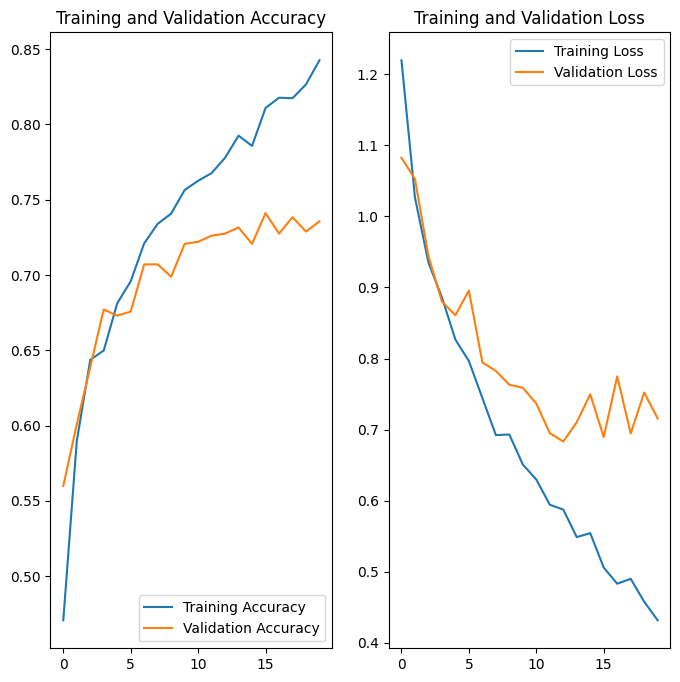

In [ ]:
# Обучение модели
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Визуализация
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Тест 1

# загружаем тестовое изображение
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# прогнозы
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

img.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
На изображении скорее всего sunflowers (99.81% вероятность)


In [ ]:
# Тест 2

roses_url = "https://lh7-us.googleusercontent.com/a3DXEq_mED1Lt8LQzWzqjCgxX2YmECTiMrpJBEbc5OcHiHkIClbkaurc8rObdr4vgBWLUoAPggnywXWh0kexXftcdZQKeSSi5BOE5zMSXxlp9GCrdc8QXFZyB8c0q_x1yS0_rVNZkE6Kw7MgBilR8bo"
roses_path = tf.keras.utils.get_file('roses', origin=roses_url)

img = tf.keras.utils.load_img(
    roses_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

img.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
На изображении скорее всего roses (97.57% вероятность)


In [ ]:
# Тест 3

dandelion_url = "https://www.tursar.ru/uploads/img3240_4.jpg"
dandelion_path = tf.keras.utils.get_file('dandelion2', origin=dandelion_url)

img = tf.keras.utils.load_img(
    dandelion_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

img.show()

444301/444301 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
На изображении скорее всего dandelion (99.74% вероятность)
